CS244 Assignment 7 - Group 8
===============

* Kevin Rothi (leader)
* John Lanier
* J.Y. Ku

Github Repository 
https://github.com/JBLanier/cs244fall2017/ 


### If you're veiwing this in PDF form, I highly recommend you view this notebook (and the others) online at:
 https://github.com/JBLanier/cs244fall2017/blob/master/assignment_8/Group8Assignment8.ipynb

We trained an SVM on a dataset comprised of J.B.'s activities, and then tested it on new activities performed by J.B., J.Y., and Kevin.

The test results have made it clear that to produce an SVM that can accurately classifiy activities done by multiple people, the classifier itself must be trained on data from many people.

### Code
Our code in this notebook is nearly identical to the code used in assignment 7; we now simply loop over multiple activities for multiple people instead of a single person. 

The board and server ran the same processes as before.

The most recent revisions to the board and server are at https://github.com/JBLanier/cs244fall2017/tree/master/assignment_6


# Activity Classification

This code is nearly the same as in past assignments (only data sets used were changed). The cell below outputs the cross validation error of the SVM on its training data, as well as the test error from each group member's activities.

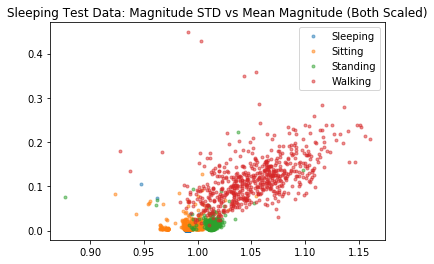

Cross Validation Accuracy: 0.8679166666666667

Test Error Rate on a 2nd 10 minute JB Sleeping data set: 0.010000000000000009
Test Error Rate on a 2nd 10 minute JB Sitting data set: 0.125
Test Error Rate on a 2nd 10 minute JB Standing data set: 0.31166666666666665
Test Error Rate on a 2nd 10 minute JB Walking data set: 0.20999999999999996

Test Error Rate on a 2nd 10 minute JY Sleeping data set: 0.0016666666666667052
Test Error Rate on a 2nd 10 minute JY Sitting data set: 0.4
Test Error Rate on a 2nd 10 minute JY Standing data set: 0.0050000000000000044
Test Error Rate on a 2nd 10 minute JY Walking data set: 0.16333333333333333

Test Error Rate on a 2nd 10 minute Kevin Sleeping data set: 0.0
Test Error Rate on a 2nd 10 minute Kevin Sitting data set: 0.9416666666666667
Test Error Rate on a 2nd 10 minute Kevin Standing data set: 0.0
Test Error Rate on a 2nd 10 minute Kevin Walking data set: 0.0016666666666667052


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn
np.random.seed(42)
%matplotlib inline

def getGeneratedFeatureData(raw_data, window_size):
    gen_features = np.full(((len(raw_data)//window_size),3),-1.0)
    for window_num, window_start_index in enumerate(range(0,len(raw_data),window_size)):
        # Check for case in which last window isn't as large as desired window_size
        if (window_start_index + window_size) > len(raw_data):
            #print("Last window at {} was too small, excluding it.".format(window_start_index))
            break
        # Gather magnitudes of data points in window
        window_magnitudes = np.full(window_size,-1.0)
        for window_index, raw_data_index in enumerate(range(window_start_index, window_start_index + window_size)):
            magnitude = np.linalg.norm(raw_data[raw_data_index][-4:-1])
            window_magnitudes[window_index] = magnitude 
            #print("c: {} index: {} W: {} values: {} magnitude: {}".format(raw_data[raw_data_index,-1],raw_data_index,window_num,raw_data[raw_data_index][:-1],magnitude))
       
        #print("Window:\n{}".format(window_magnitudes))
        #print("Mean: {} Std: {}".format(window_magnitudes.mean(),window_magnitudes.std()))
        gen_features[window_num,0] = window_magnitudes.mean()
        gen_features[window_num,1] = window_magnitudes.std()
        gen_features[window_num,2] = raw_data[0,-1]
    return gen_features

# Pull in Raw Training Data
tr_sleeping = np.genfromtxt('sleeping.csv', delimiter=',')[1:]
tr_sitting = np.genfromtxt('sitting.csv', delimiter=',')[1:]
tr_standing = np.genfromtxt('standing.csv', delimiter=',')[1:]
tr_walking = np.genfromtxt('walking.csv', delimiter=',')[1:]

# Add Class Labels
tr_sleeping = np.concatenate((tr_sleeping,np.full((len(tr_sleeping),1),1)),axis=1)
tr_sitting  = np.concatenate((tr_sitting ,np.full((len(tr_sitting) ,1),2)),axis=1)
tr_standing = np.concatenate((tr_standing,np.full((len(tr_standing),1),3)),axis=1)
tr_walking  = np.concatenate((tr_walking ,np.full((len(tr_walking) ,1),4)),axis=1)

# Trim out all but xyz and class data
tr_sleeping = tr_sleeping[:,-4:]
tr_sitting = tr_sitting[:,-4:]
tr_standing = tr_standing[:,-4:]
tr_walking = tr_walking[:,-4:]

# Generate our Final Training Data from windows of raw data (std magnitude and mean magnitude only)
window_size = 50
tr_sleeping = getGeneratedFeatureData(tr_sleeping,window_size)
tr_sitting = getGeneratedFeatureData(tr_sitting,window_size)
tr_standing = getGeneratedFeatureData(tr_standing,window_size)
tr_walking = getGeneratedFeatureData(tr_walking,window_size)

# Put Training data in one np array
train = np.concatenate((tr_sleeping,tr_sitting,tr_standing,tr_walking))

tr_X = train[:,:-1]
tr_Y = train[:,-1]

# Scale the data
scaler = StandardScaler()
scaler.fit(tr_X)
tr_X = scaler.transform(tr_X)

# Plot
df = pd.DataFrame(train)
df.columns = ['Mean', 'STD', 'Class']
groups = df.groupby('Class')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for group, label in zip(groups,['Sleeping','Sitting','Standing','Walking']):
    group = group[1]
    ax.plot(group.Mean, group.STD, marker='o', alpha = 0.5, linestyle='', ms=3, label=label)
ax.legend()
plt.title("Sleeping Test Data: Magnitude STD vs Mean Magnitude (Both Scaled)")
plt.show()

# Cross Validate on an SVM
clf = svm.SVC()
scores = cross_val_score(clf, tr_X, tr_Y, cv=5)
print('Cross Validation Accuracy: {}'.format(np.mean(scores)))

clf.fit(tr_X,tr_Y)

# Gather test data sets and set class labels

jb_sleeping = np.genfromtxt('jb_sleeping.csv', delimiter=',')[1:]
jb_sleeping = np.concatenate((jb_sleeping,np.full((len(jb_sleeping),1),1)),axis=1)
jb_sitting = np.genfromtxt('jb_sitting.csv', delimiter=',')[1:]
jb_sitting = np.concatenate((jb_sitting,np.full((len(jb_sitting),1),2)),axis=1)
jb_standing = np.genfromtxt('jb_standing.csv', delimiter=',')[1:]
jb_standing = np.concatenate((jb_standing,np.full((len(jb_standing),1),3)),axis=1)
jb_walking = np.genfromtxt('jb_walking.csv', delimiter=',')[1:]
jb_walking = np.concatenate((jb_walking,np.full((len(jb_walking),1),4)),axis=1)

jy_sleeping = np.genfromtxt('jy_sleeping.csv', delimiter=',')[1:]
jy_sleeping = np.concatenate((jy_sleeping,np.full((len(jy_sleeping),1),1)),axis=1)
jy_sitting = np.genfromtxt('jy_sitting.csv', delimiter=',')[1:]
jy_sitting = np.concatenate((jy_sitting,np.full((len(jy_sitting),1),2)),axis=1)
jy_standing = np.genfromtxt('jy_standing.csv', delimiter=',')[1:]
jy_standing = np.concatenate((jy_standing,np.full((len(jy_standing),1),3)),axis=1)
jy_walking = np.genfromtxt('jy_walking.csv', delimiter=',')[1:]
jy_walking = np.concatenate((jy_walking,np.full((len(jy_walking),1),4)),axis=1)

kevin_sleeping = np.genfromtxt('kevin_sleeping.csv', delimiter=',')[1:]
kevin_sleeping = np.concatenate((kevin_sleeping,np.full((len(kevin_sleeping),1),1)),axis=1)
kevin_sitting = np.genfromtxt('kevin_sitting.csv', delimiter=',')[1:]
kevin_sitting = np.concatenate((kevin_sitting,np.full((len(kevin_sitting),1),2)),axis=1)
kevin_standing = np.genfromtxt('kevin_standing.csv', delimiter=',')[1:]
kevin_standing = np.concatenate((kevin_standing,np.full((len(kevin_standing),1),3)),axis=1)
kevin_walking = np.genfromtxt('kevin_walking.csv', delimiter=',')[1:]
kevin_walking = np.concatenate((kevin_walking,np.full((len(kevin_walking),1),4)),axis=1)

test_sets = [jb_sleeping,jb_sitting,jb_standing,jb_walking,
            jy_sleeping,jy_sitting,jy_standing,jy_walking,
            kevin_sleeping,kevin_sitting,kevin_standing,kevin_walking]

test_set_names = ["JB Sleeping","JB Sitting","JB Standing","JB Walking",
                 "JY Sleeping","JY Sitting","JY Standing","JY Walking",
                 "Kevin Sleeping","Kevin Sitting","Kevin Standing","Kevin Walking"]

error_rates = [-1] * len(test_sets)

# Evaluate classifier performance on each test data set
for i in range(0,len(test_sets)):
    if i % 4 == 0:
        print("")
    test_data = test_sets[i]
    test_data = test_data[:,-4:]
    test_data = getGeneratedFeatureData(test_data,window_size)
    test_X = test_data[:,:-1]
    test_X = scaler.transform(test_X)
    test_Y = test_data[:,-1]
    test_accuracy = sklearn.metrics.accuracy_score(test_Y,clf.predict(test_X))
    test_error_rate = 1.0 - test_accuracy
    error_rates[i] = test_error_rate
    print("Test Error Rate on a 2nd 10 minute {} data set: {}".format(test_set_names[i],test_error_rate))

Sleeping in general had extremely low error since all members essentially didn't move during the activity.
  
J.B.'s Test error rates are accurate as expected since the training data is also based on him.
  
In J.Y's test results, we saw that her sitting activity was often misclassified as standing, and that there were very very few false negatives for standing.  
  
This trend increased to an extreme in Kevin's data, where nearly all of his sitting activity was misclassified as standing, and Kevin's standing activity did not have a single false negative. His walking activity also had extremely high accuracy.

Here we see that the movements of some group members are different enough to entirely fool an SVM trained on one person. If we had more time, we would have train the SVM on 10 minutes of each activity *from each person* rather than just from J.B.

# Vital Signs Calculation

Our vital sign calculations are unmodified from assignment 6. J.Y. and Kevin's readings look quite normal, while J.B.'s movement based activities contained much noise even after filtering, making for some erratic readings. 

After much testing, it seems that it is simply difficult to get a clean PPG signal from J.B. while others do not have this issue.

Near the bottom of this notebook, our readings are plotted, and mean vital signs are reported.

Our ppg mount:
![sensor1](https://jblanier.xyz/media/hw6_1.jpg)
![sensor1](https://jblanier.xyz/media/hw6_2.jpg)

Below are some convenience functions we made for the heavy lifting done beyond this cell. For vital sign calculation.

In [20]:
def getRatio(acRed, dcIR, acIR, dcRed):
    return float(acRed * dcIR) / (acIR * dcRed)

def calculateSPO2(R):
    return (-45.060 * math.pow(R, 2)) + (30.354 * R) + 94.845

def generateWindow(index, window_size_seconds, Fs):
    return index, index + (window_size_seconds * int(Fs))

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, [high], btype='low')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

Here we prepare our data and plot some samples of each signal. There are many plots. Note that J.B.'s signals are far noisier than the others. Scroll past this to see mean vital signs and plots required by the assignment.

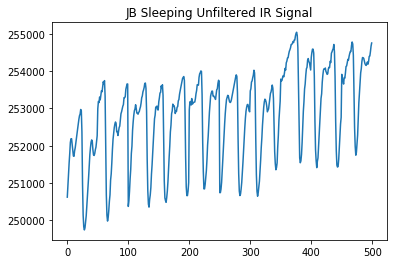

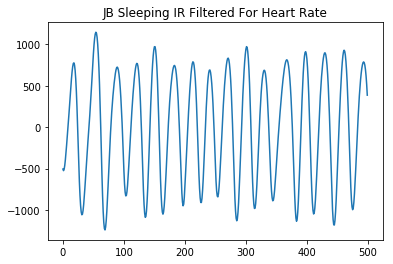

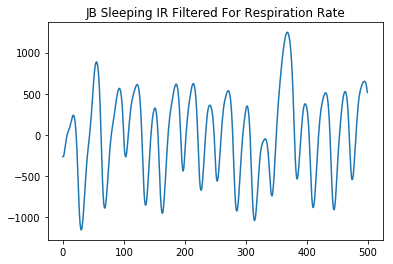

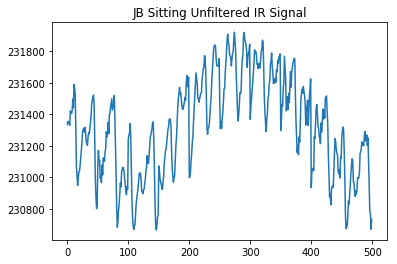

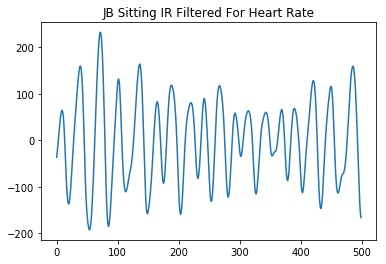

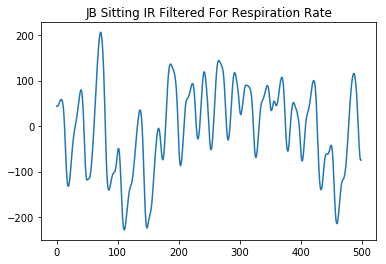

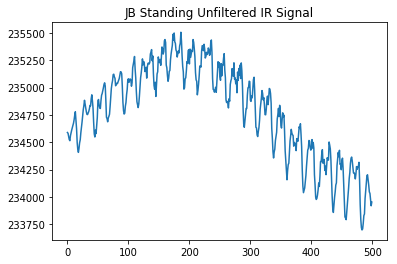

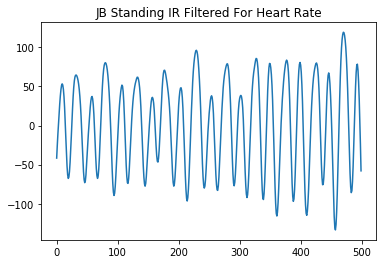

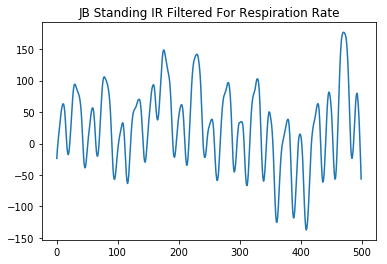

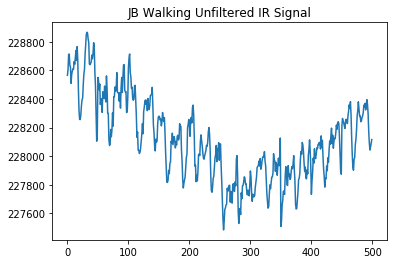

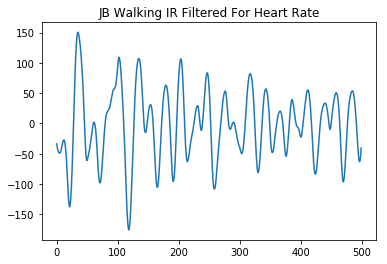

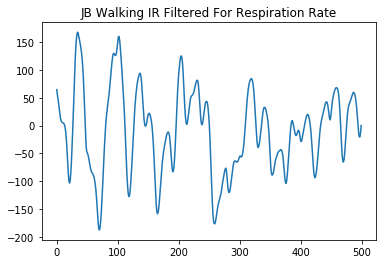

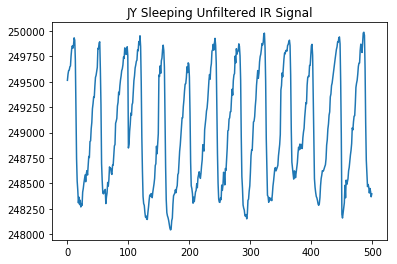

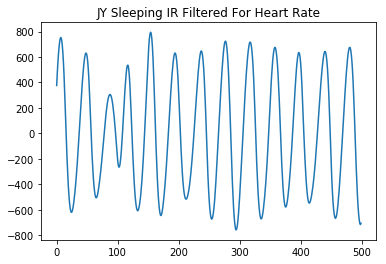

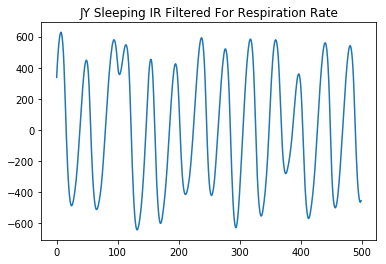

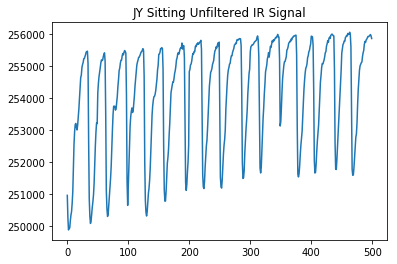

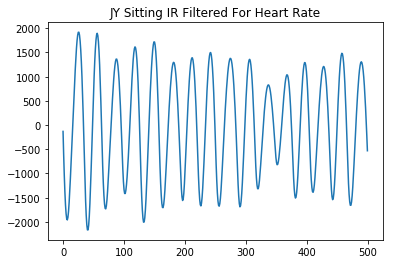

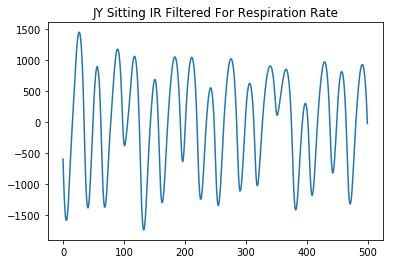

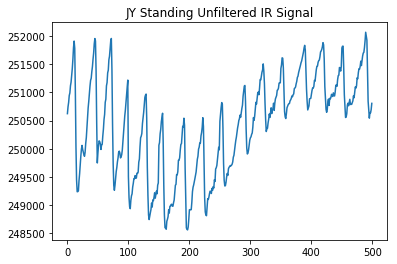

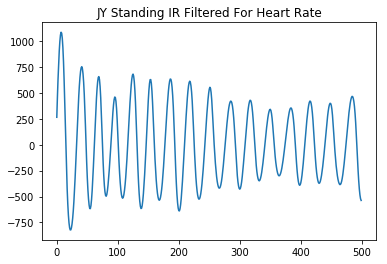

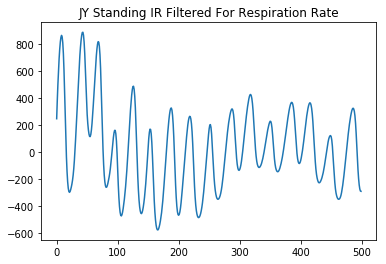

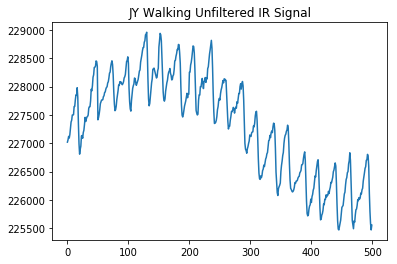

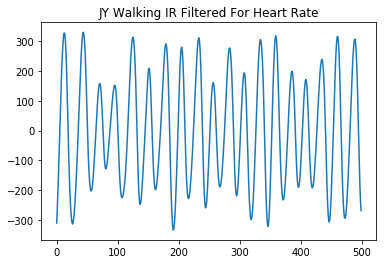

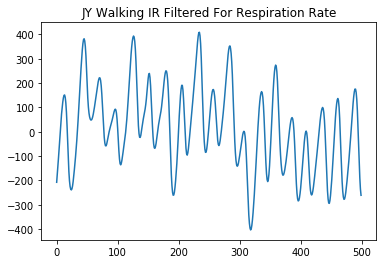

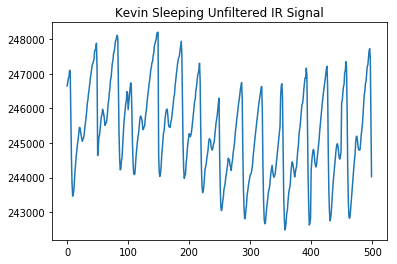

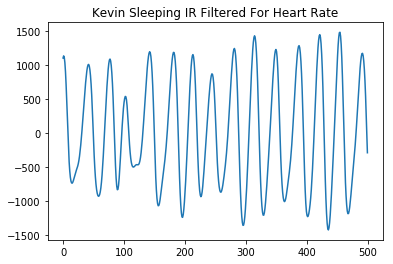

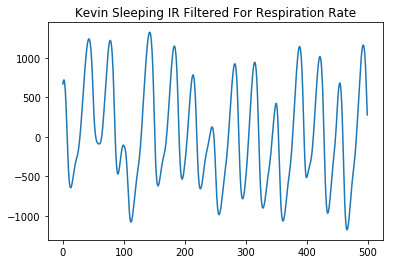

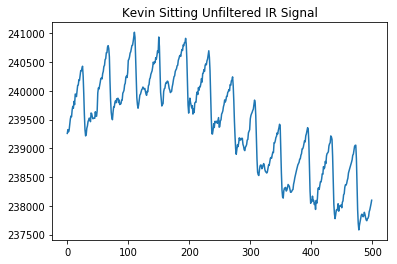

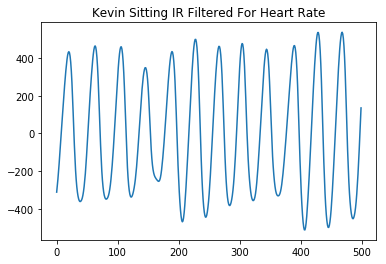

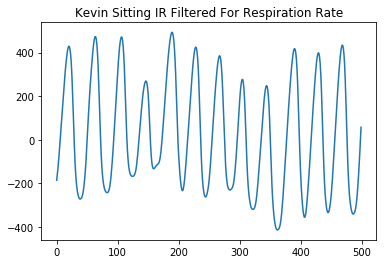

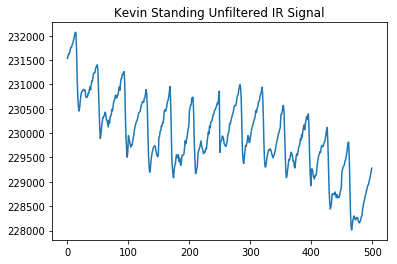

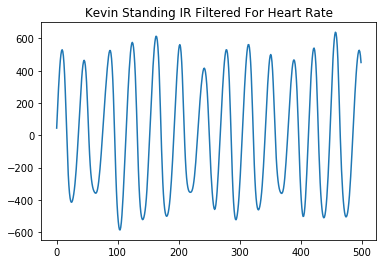

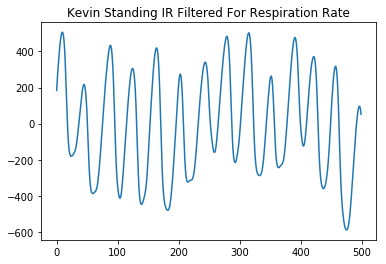

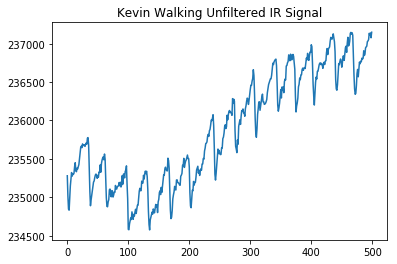

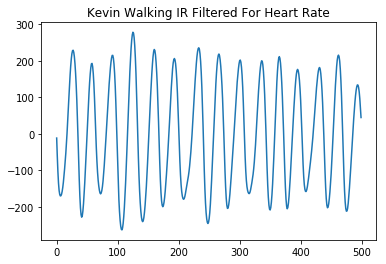

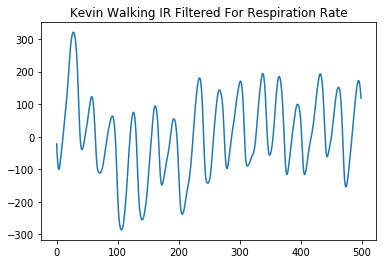

In [21]:
for i in range(0, len(test_sets)):
    
    sensor_data = test_sets[i]
    set_name = test_set_names[i]
    
    time = np.array(sensor_data[:,0]) #use the function we came up with earlier to pull out the columns for time, ir, red
    time = time - time.min()

    ir = sensor_data[:,1]
    red = sensor_data[:,2]

    Fs = len(time)/((time.max() - time.min())/1000) # Sampling Rate in Hz
    Ts = 1.0/Fs # sampling interval

    #Cutoff frequencies in Hz
    heart_rate_lowcut = 0.8
    heart_rate_highcut = 1.8

    respiration_lowcut = 0.2
    respiration_highcut = 1.5

    #filter data
    filtered_heart_rate_ir = butter_bandpass_filter(ir, heart_rate_lowcut, heart_rate_highcut, Fs, order=1)
    filtered_respiration_ir = butter_bandpass_filter(ir, respiration_lowcut, respiration_highcut, Fs, order=1)

    plt.plot(ir[50:550])
    plt.title("{} Unfiltered IR Signal".format(set_name))
    plt.show()

    plt.plot(filtered_heart_rate_ir[50:550])
    plt.title("{} IR Filtered For Heart Rate".format(set_name))
    plt.show()

    plt.plot(filtered_respiration_ir[50:550])
    plt.title("{} IR Filtered For Respiration Rate".format(set_name))
    plt.show()
    


Here we calculated vital signs in the same way that we have in assignment 7 and 6. While this cell generally outputs every single vital sign calculated, for brevity, the output of this cell is hidden, and vital signs are available in the csv's. (This output goes on forever for 4 activities from 4 people)

In [ ]:
hr_means = [-1] * len(test_sets)
rr_means = [-1] * len(test_sets)
spo2_means = [-1] * len(test_sets)

hr_exports = [None] * len(test_sets)
rr_exports = [None] * len(test_sets)
spo2_exports = [None] * len(test_sets)

hr_times = [None] * len(test_sets)
rr_times = [None] * len(test_sets)
spo2_times = [None] * len(test_sets)

for i in range(0, len(test_sets)):
    
    sensor_data = test_sets[i]
    set_name = test_set_names[i]
    
    time = np.array(sensor_data[:,0]) #use the function we came up with earlier to pull out the columns for time, ir, red
    time = time - time.min()

    ir = sensor_data[:,1]
    red = sensor_data[:,2]

    Fs = len(time)/((time.max() - time.min())/1000) # Sampling Rate in Hz
    Ts = 1.0/Fs # sampling interval

    #Cutoff frequencies in Hz
    heart_rate_lowcut = 0.8
    heart_rate_highcut = 1.8

    respiration_lowcut = 0.2
    respiration_highcut = 1.5

    #filter data
    filtered_heart_rate_ir = butter_bandpass_filter(ir, heart_rate_lowcut, heart_rate_highcut, Fs, order=1)
    filtered_respiration_ir = butter_bandpass_filter(ir, respiration_lowcut, respiration_highcut, Fs, order=1)    

    #--------------------
    #---- HR Calc -----
    #--------------------

    hrPeaks = signal.argrelextrema(filtered_heart_rate_ir, np.greater_equal, order=25)[0] 

    hr_window_size = 10
    heartRates = np.zeros(len(hrPeaks))
    heartRateTimeStampes = np.zeros(len(hrPeaks)//hr_window_size)
    print('---------- {} HR VALUES -----------'.format(set_name))
    heartRates = np.zeros(len(hrPeaks))
    for peakIndex in range(len(hrPeaks) - 1):
        if (peakIndex % hr_window_size) == 0 and peakIndex + hr_window_size < len(hrPeaks):
            heartRateTimeStampes[peakIndex//hr_window_size] = time[hrPeaks[peakIndex]]

        distance = time[hrPeaks[peakIndex + 1]] - time[hrPeaks[peakIndex]]
        heartRates[peakIndex] = (60000 / distance)
    if not len(heartRates) % hr_window_size == 0:
        heartRates = heartRates[:-(len(heartRates) % hr_window_size)]
    heartRates = np.mean(heartRates.reshape(-1, hr_window_size),axis=1)
    for r in heartRates:
        print(r)
    print('Mean: {}'.format(np.array(heartRates).mean()))
    hr_means[i] = np.array(heartRates).mean()
    hr_exports[i] = heartRates
    hr_times[i] = heartRateTimeStampes
    print('---------- END {} HR VALUES ---------------'.format(set_name))

    #--------------------
    #---- RR Calc -----
    #--------------------

    rrPeaks = signal.argrelextrema(filtered_respiration_ir, np.greater_equal, order=100)[0]

    rr_window_size = 10
    rRates = np.zeros(len(rrPeaks))
    rRateTimeStampes = np.zeros(len(rrPeaks)//rr_window_size)
    print('---------- {} RR VALUES -----------'.format(set_name))
    for peakIndex in range(len(rrPeaks) - 1):
        if (peakIndex % rr_window_size) == 0 and peakIndex + rr_window_size <= len(rrPeaks):
            rRateTimeStampes[peakIndex//rr_window_size] = time[rrPeaks[peakIndex]]

        distance = time[rrPeaks[peakIndex + 1]] - time[rrPeaks[peakIndex]]
        rRates[peakIndex] = (60000 / distance)
    if not len(rRates) % rr_window_size == 0:
        rRates = rRates[:-(len(rRates) % rr_window_size)]
    rRates = np.mean(rRates.reshape(-1, rr_window_size),axis=1)
    for r in rRates:
        print(r)
    print('Mean: {}'.format(np.array(rRates).mean()))
    rr_means[i] = np.array(rRates).mean()
    rr_exports[i] = rRates
    rr_times[i] = rRateTimeStampes
    print('---------- END {} RR VALUES ---------------'.format(set_name))

    #--------------------
    #---- SPO2 Calc -----
    #--------------------

    spo2_window_size_seconds = 3

    ir_spo2 = np.reshape(ir, len(ir))
    red_spo2 = np.reshape(red, len(red))  # shape them

    b, a = signal.butter(4, 0.8, btype='lowpass') #filter for SPO2, just removing hf noise
    filtIR = signal.filtfilt(b, a, ir_spo2, method='gust') #using filtfilt to avoid phase shift
    filtRed = signal.filtfilt(b, a, red_spo2, method='gust') 

    redDC = [] # need relevant arrays
    redAC = []
    irDC = []
    irAC = []
    spo2_timestamps = []

    index = 0
    while True:
        lb, ub = generateWindow(index, spo2_window_size_seconds, Fs) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
        if (ub > len(ir)):
            break
        redSlice = filtRed[lb:ub]
        irSlice = filtIR[lb:ub] #filtered data
        valleys = signal.argrelmin(redSlice, order=10)[0] #find peaks and valleys
        peaks = signal.argrelmax(redSlice, order=10)[0]
        valley1 = valleys[0] + lb
        valley2 = valleys[1] + lb
        peak = peaks[0] + lb
        if (peak < valley1): #to make sure the peak is between the valleys
            peak = peaks[1] + lb
        dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
        dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
        testSPO2 = calculateSPO2(getRatio(filtRed[peak] - dcred, dcir, filtIR[peak] - dcir, dcred))
        if testSPO2 < 96.0 or testSPO2 > 99.9: # garbage value? let's try searching for peaks dynamically
            attempts = 0
            while (testSPO2 < 96.0 or testSPO2 > 99.9) and attempts < 14 : # try orders from 6 - 19
                valleys = signal.argrelmin(redSlice, order=6 + attempts)[0] #find peaks and valleys
                peaks = signal.argrelmax(redSlice, order=6 + attempts)[0]
                if (len(valleys) < 2 or len(peaks) < 2):
                    break; # no peaks or valleys?
                valley1 = valleys[0] + lb
                valley2 = valleys[1] + lb
                peak = peaks[0] + lb
                if (peak < valley1): #to make sure the peak is between the valleys
                    peak = peaks[1] + lb
                dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
                dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
                attempts = attempts + 1
        irDC += [dcir]
        irAC += [filtIR[peak] - dcir]
        redDC += [dcred]
        redAC += [filtRed[peak] - dcred]
        spo2_timestamps.append(time[index])

        index = ub

    print('---------- {} SPO2 VALUES -----------'.format(set_name))
    spo2s = []
    for iteration in range(len(redDC)):
        spo2_val = calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration]))
        
        # If spo2 value is nonsese, change it to 100 to not have a signficant effect on calculating the mean. 
        # 100 means spo2 calculation failed
        if spo2_val < 70 or spo2_val > 100:
            spo2_val = 100
            
        spo2s.append(spo2_val)
        print(spo2_val)
    print('Mean: {}'.format(np.array(spo2s).mean()))
    spo2_means[i] = np.array(spo2s).mean()
    spo2_exports[i] = spo2s
    spo2_times[i] = spo2_timestamps
    print('---------- END {} SPO2 VALUES -----------'.format(set_name))

Here mean vital signs are calculated:

In [27]:
for i in range(0,len(test_sets)):
    if i % 4 == 0:
        print("\n")
    print("{} HR Mean: {}".format(test_set_names[i],hr_means[i]))
    print("{} RR Mean: {}".format(test_set_names[i],rr_means[i]))
    print("{} SPO2 Mean: {}\n".format(test_set_names[i],spo2_means[i]))



JB Sleeping HR Mean: 74.58648932791328
JB Sleeping RR Mean: 15.619418013996595
JB Sleeping SPO2 Mean: 99.70500386979165

JB Sitting HR Mean: 69.5930672867826
JB Sitting RR Mean: 14.305302348106126
JB Sitting SPO2 Mean: 97.61722479447467

JB Standing HR Mean: 56.584583282257626
JB Standing RR Mean: 12.391517198076649
JB Standing SPO2 Mean: 95.45455448911889

JB Walking HR Mean: 59.27026716840343
JB Walking RR Mean: 14.704103102808812
JB Walking SPO2 Mean: 93.39624376682607



JY Sleeping HR Mean: 66.37468241702226
JY Sleeping RR Mean: 14.670739312120674
JY Sleeping SPO2 Mean: 99.84137137752131

JY Sitting HR Mean: 81.32085938612151
JY Sitting RR Mean: 12.331209762477295
JY Sitting SPO2 Mean: 99.6800625924227

JY Standing HR Mean: 77.5396463991716
JY Standing RR Mean: 13.041656969786219
JY Standing SPO2 Mean: 99.35413408247318

JY Walking HR Mean: 63.244851663549156
JY Walking RR Mean: 13.446284194788802
JY Walking SPO2 Mean: 97.66630713644196



Kevin Sleeping HR Mean: 75.932696435451

Below are the required plots:

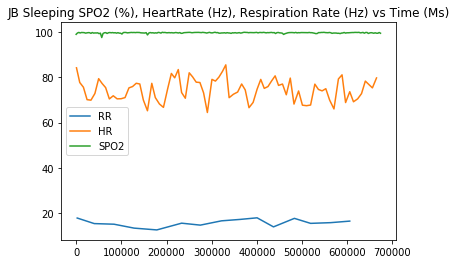

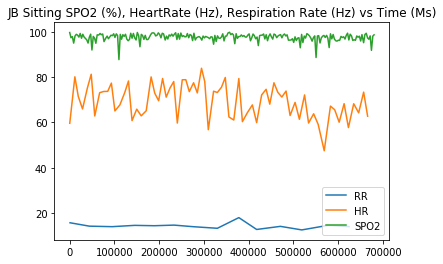

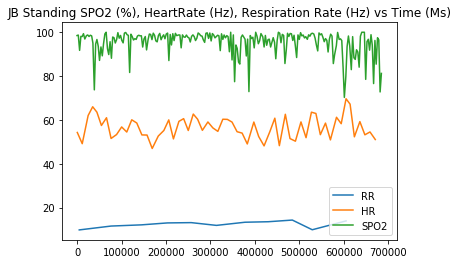

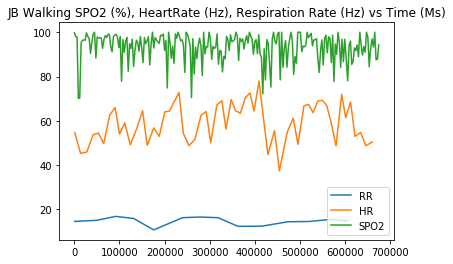

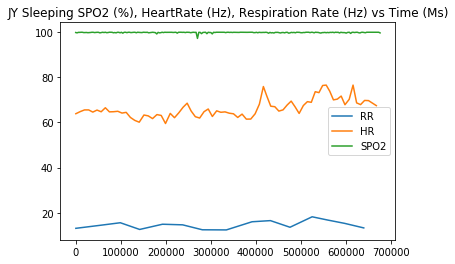

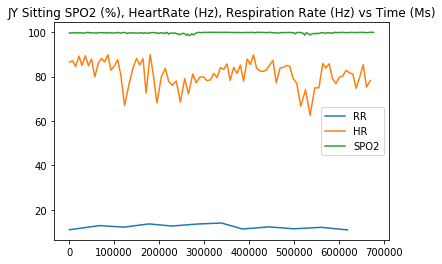

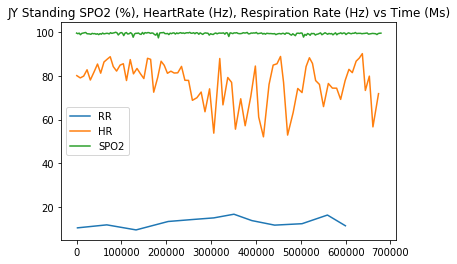

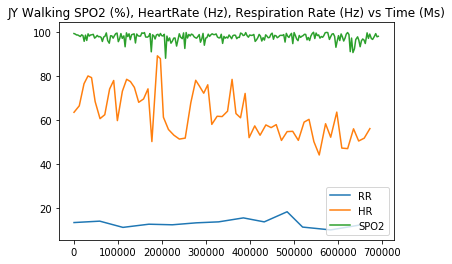

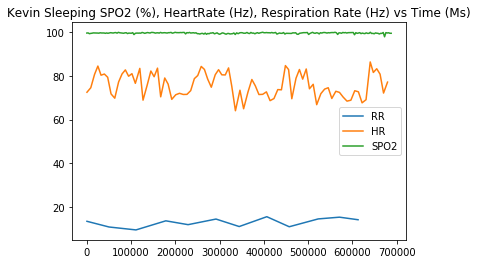

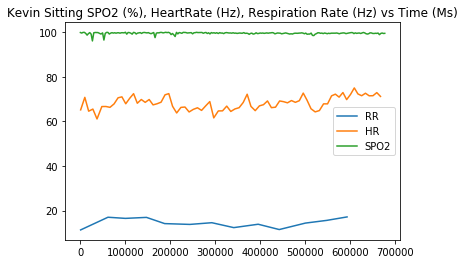

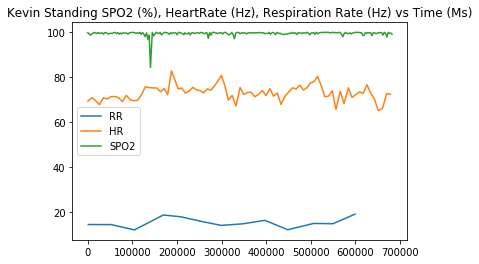

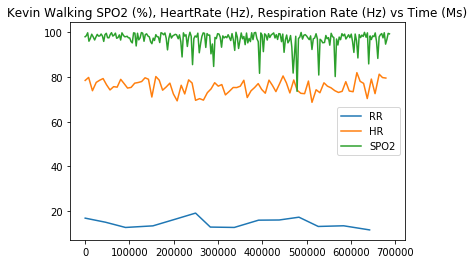

In [24]:
for i in range(0,len(test_sets)):
    plt.plot(rr_times[i],rr_exports[i],label="RR")
    plt.plot(hr_times[i],hr_exports[i],label="HR")
    plt.plot(spo2_times[i], spo2_exports[i],label="SPO2")
    plt.legend()
    plt.title("{} SPO2 (%), HeartRate (Hz), Respiration Rate (Hz) vs Time (Ms)".format(test_set_names[i]))
    plt.show()

Here we export requested values to a csv:

In [30]:
file_names = ["jblanier_assignment8_sleeping.csv",
          "jblanier_assignment8_sitting.csv",
          "jblanier_assignment8_standing.csv",
          "jblanier_assignment8_walking.csv",
          "jungyok_assignment8_sleeping.csv",
          "jungyok_assignment8_sitting.csv",
          "jungyok_assignment8_standing.csv",
          "jungyok_assignment8_walking.csv",
          "krothi_assignment8_sleeping.csv",
          "krothi_assignment8_sitting.csv",
          "krothi_assignment8_standing.csv",
          "krothi_assignment8_walking.csv",]

for i in range(0,len(test_sets)):
    test_data = test_sets[i]
    
    d = {'IR': pd.Series(test_data[:,1]),
         'RED': pd.Series(test_data[:,2]),
         'X': pd.Series(test_data[:,3]),
         'Y': pd.Series(test_data[:,4]),
         'Z': pd.Series(test_data[:,5]),
         'Heart Rate': pd.Series(hr_exports[i]),
         'Respiration Rate': pd.Series(rr_exports[i]),
         'SPO2': pd.Series(spo2_exports[i]),
         'Classifier Error Rate': pd.Series(error_rates[i])
        }
    
    export_df = pd.DataFrame(d)
    export_df = export_df[['IR','RED','X','Y','Z','Heart Rate','Respiration Rate','SPO2','Classifier Error Rate']]
    export_df.to_csv(file_names[i], index=False)